###**ATOC4500 Data Science Lab: Final Project**
###**Influence of Humidity on PM2.5 Measurements in Boulder, CO**
###Author: Rachel Mooers, rachel.mooers@colorado.edu###
###last updated: April 18, 2022###

**>>>> This code is available on github at (insert URL)**

**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

###**Introduction:** 
The objective of this project is to use PM2.5 (particulate matter with a diameter less than or equal to 2.5 microns in diamerter) measurements from two different types of sensors (a FRM and a low-cost optical particle scattering instrument) to determine what correlations exist between relative humidity and PM2.5 concentrations for each sensor. **I hypothesize that PM2.5 measured by the PurpleAir sensor will be more strongly correlated with relative humidity than PM2.5 measured by an EPA FRM monitor.** The EPA FRM obtains PM2.5 measurements by collecting deposits over 24-hour periods on Teflon-membrane filters from air drawn at a controlled rate through a PM2.5 inlet, then weighting the filter after sampling to determine the mass of PM2.5. Since this is a direct measurement of mass and the Teflon-membrane filter is hydrophobic, it should not be strongly influenced by humidity. The PurpleAir sensor measures total scattering of particles in a laser beam (like a nephelometer) and then derives particle counts using algorithms and an assumed particle distribution representative of urban pollution. This leads to erroneous distributions if the particle size distribution differs from the algorithm’s assumed size distribution or if factors such as humidity influence the scattering signal.

**Citations:**   
Callahan, J. (2020, May 8). Documents: PurpleAir cf=ATM vs cf=1. MazamaScience. Retrieved April 20, 2022, from https://rdrr.io/github/MazamaScience/AirSensor/f/documents/PurpleAir_CF%3DATM_vs_CF%3D1.md   

Di Antonio, A., Popoola, O., Ouyang, B., Saffell, J., & Jones, R. (2018). Developing a relative humidity correction for low-cost sensors measuring ambient particulate matter. Sensors, 18(9), 2790. https://doi.org/10.3390/s18092790

List of designated reference and equivalent methods . EPA . (2021, December 15). Retrieved April 20, 2022, from https://www.epa.gov/system/files/documents/2021-12/designated-referene-and-equivalent-methods-12152021.pdf   

Jayaratne, R., Liu, X., Thai, P., Dunbabin, M., & Morawska, L. (2018). The influence of humidity on the performance of a low-cost air particle mass sensor and the effect of atmospheric fog. Atmospheric Measurement Techniques, 11(8), 4883–4890. https://doi.org/10.5194/amt-11-4883-2018

Mooers, R. (2021, October 15). Investigation of the performance of a purpleair particulate matter sensor for measuring submicron-size aerosols. CU Scholar. Retrieved April 20, 2022, from https://scholar.colorado.edu/concern/undergraduate_honors_theses/th83m037v 


In [113]:
# Importing packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
from sklearn.metrics import r2_score
import datetime
from google.colab import files
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.dates as mdates
import csv
from scipy import stats
from sklearn import linear_model
from sklearn import metrics
import matplotlib.dates

###**Step 1: Read in data** 
**EPA PM2.5 Daily Measurements:**    
This data is from a reference-standard PM2.5 monitoring station in central Boulder, CO run by the EPA. This station collects daily measurements. Particulate matter smaller than 2.5 microns in diameter is drawn through an inlet then collected on a filter which is weighed at the end of each 24-hour sampling period. This dataset spans 2016 through 2021 but has numerous missing values. The EPA conducts quality control on the data before it is made publicly available. 

**PurpleAir PM Daily Measurements:**
This data is from a low-cost, "citizen-science" PurpleAir sensor located near Gunbarrel in Boulder, CO. This sensor collects measurements every two minutes by using a laser and optical particle scattering principles to obtain values of particulate matter. The data was downloaded as 1-day averages to compare with the EPA data and is from 2020 through 2021 with some missing values in 2020. Because this is a "citizen-science" instrument, no quality control has been conducted, however PurpleAir provides both raw PM2.5 data and PM2.5 data with a correction factor in dataset. 

**Mesa Lab Meteorological Data:** 
The NCAR Mesa Lab is located in southwest Boulder, CO and collects meteorologcal data, including relative humidity which will be used in this analysis. Professor Kay has already munged this dataset (from 2016 through 2021) and it has an hourly resolution. I will take daily averages in order to compare it with the PM2.5 datasets. 

In [93]:
### upload file ATOC4500_FinalProject_data_Mooers.xlsx
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ATOC4500_FinalProject_data_Mooers.xlsx to ATOC4500_FinalProject_data_Mooers (3).xlsx
User uploaded file "ATOC4500_FinalProject_data_Mooers.xlsx" with length 3083955 bytes


In [94]:
# Checking that all three sheets from the excel sheet were imported 
# Should print "['EPA', 'PurpleAir', 'Mesa Lab']"
xl = pd.ExcelFile('ATOC4500_FinalProject_data_Mooers.xlsx')
xl.sheet_names

['EPA', 'PurpleAir', 'Mesa Lab']

In [95]:
# reading in each datset as a Pandas dataframe 
epa = pd.read_excel('ATOC4500_FinalProject_data_Mooers.xlsx', 'EPA')
purpleair = pd.read_excel('ATOC4500_FinalProject_data_Mooers.xlsx', 'PurpleAir')
mesa = pd.read_excel('ATOC4500_FinalProject_data_Mooers.xlsx', 'Mesa Lab')

###**Step 2: Munge data**

1. Remove columns from the dataframes with variables I will not be using in my statistical analyses in order to make the dataframes more concise.  
2. Rename columns to clearly describe what is in them and so that there is consistency across dataframes (e.g. all dates are in columns labeled "Date").  
3. Convert all temporal columns into datetime format. This will enable taking daily averages, plotting variables over time, and filtering data temporally later on.  
4. Drop NaN values so that data can be plotted and numerical analyses can be conducted. All rows containing NaN values are dropped, but this will not bias my statistical analyses data will be sorted by only days when data from all three datasets is available. 
5. Filter the dataframes by only dates that are available in all three datasets. These are the dataframes I will use in the rest of the notebook and have "_new" appended to their dataframe names. 

In [96]:
# removing columns that I will not use 
epa = epa.drop(['Source', 'Site ID', 'POC', 'Site Name', 'DAILY_OBS_COUNT', 
                'PERCENT_COMPLETE', 'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC', 
                'CBSA_CODE', 'CBSA_NAME', 'STATE_CODE', 'STATE', 'COUNTY_CODE', 
                'COUNTY'], axis=1)
purpleair = purpleair.drop(['PM1.0_CF1_ug/m3', 'PM10.0_CF1_ug/m3', 'RSSI_dbm', 
                            'UptimeMinutes'], axis=1)
mesa = mesa.drop(['pres_mb', 'wdir', 'wspd_m_per_s', 'wspdmax_m_per_s', 
                  'raina_event_mm'], axis=1)

# renaming columns of the dataframes 
epa.columns = ['Date', 'PM2.5', 'Units', 'Daily AQI', 'Latitude', 'Longitude']
purpleair.columns = ['Date', 'PM2.5 (raw)', 'Temp (F)', 'RH', 
                     'PM2.5 (corrected)']
mesa.columns = ['Date', 'Hour', 'Temp (C)', 'RH', 'Year']

# converting times into DateTime format 
epa['Date'] = pd.to_datetime(purpleair['Date'], format='%Y-%m-%d %X %Z')
purpleair['Date'] = pd.to_datetime(purpleair['Date'], format='%Y-%m-%d %X %Z')
mesa['Date'] = pd.to_datetime(mesa['Date'], format='%Y-%m-%d')
mesa['Hour'] = pd.to_datetime(mesa['Hour'], format='%H')
mesa['Year'] = pd.to_datetime(mesa['Year'], format='%Y')

# Dropping nan values 
epa = epa.dropna()
purpleair = purpleair.dropna()
mesa = mesa.dropna()

In [97]:
# checking data types of each dataframe column 
epa_types = epa.dtypes 
print('EPA Data Types:')
print(epa_types)
print('')

purpleair_types = purpleair.dtypes
print('PurpleAir Data Types:')
print(purpleair_types)
print('')

mesa_types = mesa.dtypes
print('Mesa Lab Data Types:')
print(mesa_types)

EPA Data Types:
Date         datetime64[ns, UTC]
PM2.5                    float64
Units                     object
Daily AQI                  int64
Latitude                 float64
Longitude                float64
dtype: object

PurpleAir Data Types:
Date                 datetime64[ns, UTC]
PM2.5 (raw)                      float64
Temp (F)                         float64
RH                               float64
PM2.5 (corrected)                float64
dtype: object

Mesa Lab Data Types:
Date        datetime64[ns]
Hour        datetime64[ns]
Temp (C)           float64
RH                 float64
Year        datetime64[ns]
dtype: object


In [98]:
# creating dataframe for daily Mesa Lab averages
mesa_avg = mesa.groupby(mesa['Date'].dt.date).mean()

# fixing indexing error introduced by groupby
mesa_avg = mesa_avg.reset_index()

# changing date into datetime format that can be compared with Mesa data
epa['Date'] = epa['Date'].dt.strftime("%Y-%m-%d")
purpleair['Date'] = purpleair['Date'].dt.strftime("%Y-%m-%d")
epa['Date'] = pd.to_datetime(purpleair['Date'], format='%Y-%m-%d')
purpleair['Date'] = pd.to_datetime(purpleair['Date'], format='%Y-%m-%d')
mesa_avg['Date'] = pd.to_datetime(mesa_avg['Date'], format='%Y-%m-%d')

# NOTE: from here on I will only use the mesa_avg dataset that...
#  ...contains daily averages 
# this only kept float and int columns
# the only remaining columns are Date, Temperature, and RH

# checking data types again to make sure all dates are datetime
epa_types = epa.dtypes 
print('EPA Data Types:')
print(epa_types)
print('')

purpleair_types = purpleair.dtypes
print('PurpleAir Data Types:')
print(purpleair_types)
print('')

mesa_avg_types = mesa_avg.dtypes
print('Mesa Lab Data Types:')
print(mesa_avg_types)

EPA Data Types:
Date         datetime64[ns]
PM2.5               float64
Units                object
Daily AQI             int64
Latitude            float64
Longitude           float64
dtype: object

PurpleAir Data Types:
Date                 datetime64[ns]
PM2.5 (raw)                 float64
Temp (F)                    float64
RH                          float64
PM2.5 (corrected)           float64
dtype: object

Mesa Lab Data Types:
Date        datetime64[ns]
Temp (C)           float64
RH                 float64
dtype: object


In [99]:
# Checking that the EPA dataframe looks reasonable 
# epa.head()
# purpleair.head()
mesa_avg.head()

,Date,Temp (C),RH
0,2016-01-01,-5.829167,49.020833
1,2016-01-02,0.975000,18.525000
2,2016-01-03,2.912500,21.791667
3,2016-01-04,3.145833,34.641667
4,2016-01-05,5.020833,30.220833


In [100]:
# used this stack overflow page as a reference: 
# https://stackoverflow.com/questions/36893011/pandas-filter-values-by-date
# created two "is_shared" masks, then filtered by rows where both are true

# creating boolean masks 
is_shared11 = np.in1d(epa['Date'], purpleair['Date'])
is_shared12 = np.in1d(purpleair['Date'], epa['Date'])
is_shared21 = np.in1d(mesa_avg['Date'], purpleair['Date'])
is_shared22 = np.in1d(purpleair['Date'], mesa['Date'])
is_shared31 = np.in1d(epa['Date'], mesa['Date'])
is_shared32 = np.in1d(mesa_avg['Date'], epa['Date'])

# adding boolean mask columns to dataframes
epa['time_shared1'] = is_shared11
epa['time_shared2'] = is_shared31
purpleair['time_shared1'] = is_shared12
purpleair['time_shared2'] = is_shared22
mesa_avg['time_shared1'] = is_shared21
mesa_avg['time_shared2'] = is_shared32

# filtering by when all dates match 
# creating new dataframes with names "_new"
# NOTE: these are the dataframes I will use in the statistical analyses 
epa_new = epa[epa[['time_shared1','time_shared2']].all(1)]
purpleair_new = purpleair[purpleair[['time_shared1','time_shared2']].all(1)]
mesa_new = mesa_avg[mesa_avg[['time_shared1','time_shared2']].all(1)]

In [101]:
# Checking to make sure the dataframes look reasonable
# epa_new.head()
# purpleair_new.head()
# mesa_new.head()
print(len(epa_new))
print(len(purpleair_new))
print(len(mesa_new))

592
592
592


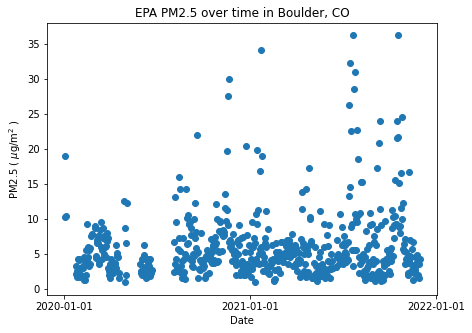

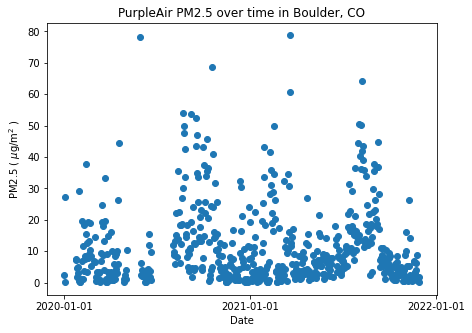

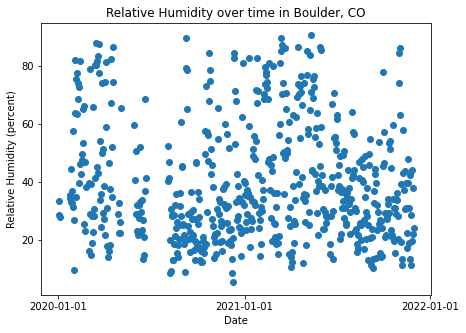

In [102]:
# creating plots to visualize data 

# plotting a timeseries of PurpleAir PM2.5 data 
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(epa_new['Date'], epa_new['PM2.5'])
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('EPA PM2.5 over time in Boulder, CO')
ax.set_xlabel('Date')
ax.set_ylabel(r'PM2.5 ( $\mu$g/m$^2$ )')
plt.show()

# plotting a timeseries of EPA Pm2.5 data 
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(purpleair_new['Date'], purpleair_new['PM2.5 (corrected)'])
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('PurpleAir PM2.5 over time in Boulder, CO')
ax.set_xlabel('Date')
ax.set_ylabel(r'PM2.5 ( $\mu$g/m$^2$ )')
plt.show()

# plotting a timeseries of Mesa Lab RH data
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(mesa_new['Date'], mesa_new['RH'])
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.set_title('Relative Humidity over time in Boulder, CO')
ax.set_xlabel('Date')
ax.set_ylabel(r'Relative Humidity (percent)')
plt.show()

###**Step 3: Apply Data Science Methods**

include description of step 3 here, include assumptions

*   Linear regression
*   Find autocorrelation (with caveat that spacing is not consistent)
*   Use t-test to find significance for when null hypothesis is that there is no correlation (EPA dataset) 
*   Use Fisher-Z transformation for when null hypothesis is that correlation is non-zero (PurpleAir)

### Calculating autocorrelations   
I am definitely doing something wrong; N* should not be negative 

In [103]:
# calculating effective sample sizes for each dataset 
# there is the problem where the data does not have... 
# ...an evenly spaced temporal resolution 
# Calculate the autocorrelation using numpy dot (direct calculation)
# (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)

# for EPA data 
tseries1=epa_new['PM2.5']
n=len(tseries1)
sigma=1
lag=1
## Barnes Chapter 2 Eq. 68 divided by the variance
alpha=np.dot(tseries1[0:-1*lag],tseries1[lag:])/(n-lag)/sigma**2 
print('lag',lag,'EPA PM2.5 autocorrelation:',round(alpha,3))
## calculate N*
## Chapter 2 Barnes Eq. 88
epa_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) 
print('independent samples, N*: ',epa_nstar)
print('')

# for PurpleAir data 
tseries2=purpleair_new['PM2.5 (corrected)']
n=len(tseries2)
sigma=1
lag=1
## Barnes Chapter 2 Eq. 68 divided by the variance
alpha=np.dot(tseries2[0:-1*lag],tseries2[lag:])/(n-lag)/sigma**2 
print('lag',lag,'PurpleAir PM2.5 autocorrelation:',round(alpha,3))
## calculate N*
## Chapter 2 Barnes Eq. 88
purpleair_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) 
print('independent samples, N*: ',purpleair_nstar)
print('')

# for Mesa Lab data 
tseries3=mesa_new['RH']
n=len(tseries3)
sigma=1
lag=1
## Barnes Chapter 2 Eq. 68 divided by the variance
alpha=np.dot(tseries3[0:-1*lag],tseries3[lag:])/(n-lag)/sigma**2 
print('lag',lag,'Mesa Lab RH autocorrelation:',round(alpha,3))
## calculate N*
## Chapter 2 Barnes Eq. 88
mesa_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) 
print('independent samples, N*: ',mesa_nstar)

lag 1 EPA PM2.5 autocorrelation: 48.057
independent samples, N*:  -568.0

lag 1 PurpleAir PM2.5 autocorrelation: 221.847
independent samples, N*:  -587.0

lag 1 Mesa Lab RH autocorrelation: 1821.891
independent samples, N*:  -591.0


### Linear Regression Statistics & Plot for EPA PM2.5 vs. PurpleAir PM2.5  


Slope: 0.04
Intercept: 11.08
R_Value: 0.01
Percent variance explained: 0.0 %
R_Squared: 0.0001985492673198179


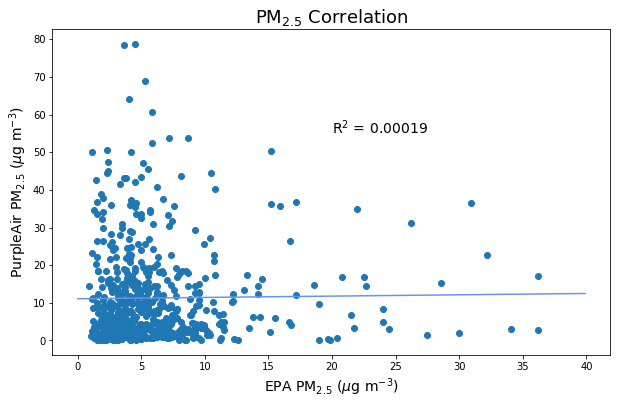

In [104]:
# EPA PM2.5 versus PurpleAir PM2.5 (corrected)

# calculating linear regression statistics 
slope, intercept, r_value, p_value, std_err = stats.linregress(epa_new['PM2.5'],\
      purpleair_new['PM2.5 (corrected)'])
print('Slope:', round(slope,2))
print('Intercept:', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')
r_squared = (r_value)**2
print('R_Squared:', r_squared)

# linear regression line to plot 
fit_x = np.arange(0,40,.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)

# fonts for plot labels 
font1 = {'family' : 'Helvetica',
        'size'   : 14}
font2 = {'family' : 'Helvetica',
        'size'   : 18}

# plotting PM2.5 correlation for EPA vs PurpleAir 
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(epa_new['PM2.5'], purpleair_new['PM2.5 (corrected)'])
ax.plot(fit_x,fit_y,c='cornflowerblue')
ax.set_title(r'PM$_{2.5}$ Correlation', **font2)
ax.set_xlabel(r'EPA PM$_{2.5} \ (\mu$g m$^{-3}$)', **font1)
ax.set_ylabel(r'PurpleAir PM$_{2.5} \ (\mu$g m$^{-3}$)', **font1)
plt.text(20, 55, r'R$^2$ = 0.00019', fontsize=12, **font1)
plt.show()

# Notes: 
# Does not have a strong correlation - almost zero correlation!
# This could be a result of spatial variation in air quality 

### Confidence Testing for EPA PM2.5 and PurpleAir PM2.5 correlation 

**Null hypothesis:** The correlation between EPA PM2.5 and PurpleAir PM2.5 is positive. 

In [105]:
## Calculate the Fisher-Z Transformation mean, Barnes Ch. 2 Eq. 52
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #2')
print('Null Hypothesis: The true correlation is not zero.')
mu_Z=0.5*np.log((1+r_value)/(1-r_value)) 
print('mu_Z:',np.round(mu_Z,2))
N=len(purpleair_new['Date'])
df=N-3                    ## Calculate the degrees of freedom
sigma_Z=1/np.sqrt(df)     ## Calculate the Fisher-Z Transformation standard deviation Barnes Ch. 2 Equation 53
print('sigma_Z:',np.round(sigma_Z,2))

## Calculate the critical value, i.e., the t-statistic
tstat95=stats.t.ppf(0.975,df)  ## two-sided 95%
print('tstat95',round(tstat95,3))
## Calculate the confidence intervals on the mean (mu_Z)
Zmin=mu_Z-tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
Zmax=mu_Z+tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
print('Zmin (minimum 95% confidence interval)',round(Zmin,2))
print('Zmax (maximum 95% confidence interval)',round(Zmax,2))

## Convert to give a confidence interval on the correlation using Barnes Ch. 2 Eq. 55
rho_min=np.tanh(Zmin)
rho_max=np.tanh(Zmax)
print('Rhomin (minimum 95% confidence interval for true r_value):',round(rho_min,2))
print('Rhomax (maximum 95% confidence interval for true r_value):',round(rho_max,2))

print('If the confidence bounds do include 0 -- we reject the null hypothesis')
print('If the confidence bounds do not include 0 -- we fail to reject the null hypothesis')

# the confidence bounds include zero 
# therefore, we reject the null hypothesis 
# this implies that there is a statistically significant... 
# ...lack of correlation between the sensors 

ASSESS SIGNIFICANCE OF REGRESSION METHOD #2
Null Hypothesis: The true correlation is not zero.
mu_Z: 0.01
sigma_Z: 0.04
tstat95 1.964
Zmin (minimum 95% confidence interval) -0.07
Zmax (maximum 95% confidence interval) 0.1
Rhomin (minimum 95% confidence interval for true r_value): -0.07
Rhomax (maximum 95% confidence interval for true r_value): 0.09
If the confidence bounds do include 0 -- we reject the null hypothesis
If the confidence bounds do not include 0 -- we fail to reject the null hypothesis


### Linear Regression Statistics & Plot for Mesa Lab RH vs. PurpleAir RH 


Slope: 0.61
Intercept: 12.63
R_Value: 0.88
Percent variance explained: 76.6 %
R_Squared: 0.7657167854193025


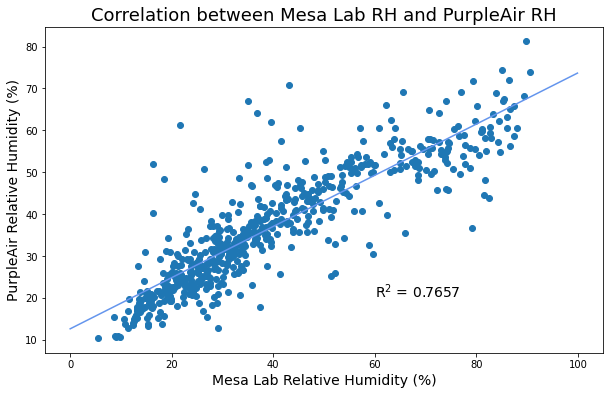

In [106]:
# Mesa Lab RH versus PurpleAir RH 

# calculating linear regression statistics 
slope, intercept, r_value, p_value, std_err = stats.linregress(mesa_new['RH'], \
      purpleair_new['RH'])
print('Slope:', round(slope,2))
print('Intercept:', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')
r_squared = (r_value)**2
print('R_Squared:', r_squared)

# linear regression line to plot 
fit_x = np.arange(0,100,.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)

# plotting correlation between Mesa Lab RH and Purpleair RH
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(mesa_new['RH'], purpleair_new['RH'])
ax.plot(fit_x,fit_y,c='cornflowerblue')
ax.set_title('Correlation between Mesa Lab RH and PurpleAir RH', **font2)
ax.set_xlabel('Mesa Lab Relative Humidity (%)', **font1)
ax.set_ylabel('PurpleAir Relative Humidity (%)', **font1)
plt.text(60, 20, r'R$^2$ = 0.7657', fontsize=12, **font1)
plt.show()

# Notes: 
# RH values from the two sensors are reasonably correlated 
# Indicates that the RH sensors work... 
# ...and no considerable variability over the few kilometers between sensors 

### Linear Regression Statistics & Plot for Mesa Lab RH vs. EPA PM2.5  


Slope: -0.03
Intercept: 7.19
R_Value: -0.11
Percent variance explained: 1.3 %
R_Squared: 0.012661608547765863


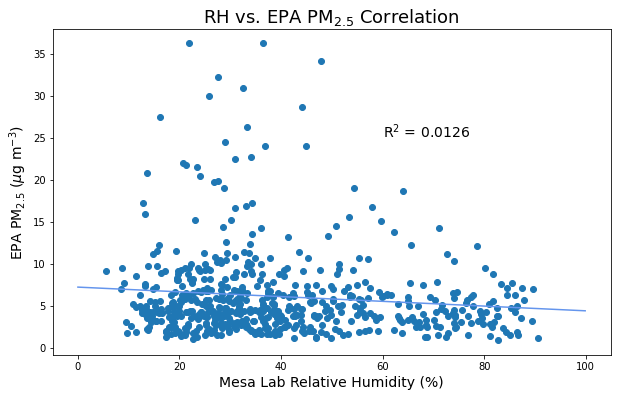

In [107]:
# Mesa Lab RH versus EPA PM2.5

# calculating linear regression statistics 
slope, intercept, r_value, p_value, std_err = stats.linregress(mesa_new['RH'], \
      epa_new['PM2.5'])
print('Slope:',round(slope,2))
print('Intercept:', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')
r_squared = (r_value)**2
print('R_Squared:', r_squared)

# linear regression line to plot 
fit_x = np.arange(0,100,.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)

# plotting correlation between RH and EPA PM2.5
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(mesa_new['RH'], epa_new['PM2.5'])
ax.plot(fit_x,fit_y,c='cornflowerblue')
ax.set_title(r'RH vs. EPA PM$_{2.5}$ Correlation', **font2)
ax.set_xlabel('Mesa Lab Relative Humidity (%)', **font1)
ax.set_ylabel(r'EPA PM$_{2.5} \ (\mu$g m$^{-3}$)', **font1)
plt.text(60, 25, r'R$^2$ = 0.0126', fontsize=12, **font1)
plt.show()

### Confidence Testing for RH and EPA PM2.5 correlation 

**Null hypothesis:** The correlation between relative humidity and PM2.5 meeasured by the EPA is 0. 

In [108]:
### Method #1: H0 (null hypothesis) correlation is 0  
## similar to Barnes Worked Problem 2.1
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #1')
print('Null Hypothesis: The true correlation is zero.')

N = len(epa_new['Date'])
dof=N-2 # degrees of freedom 
print("Degrees of Freedom: ",dof)

tcrit=stats.t.ppf(0.975,N-2)  ## two-sided 95%
print('tcrit=',round(tcrit,2))

t=r_value*np.sqrt(N-2)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))

if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),\
        ' we can reject the null hypothesis')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),\
        'we cannot reject the null hypothesis')
  
# we fail to reject the null hypotheis 

ASSESS SIGNIFICANCE OF REGRESSION METHOD #1
Null Hypothesis: The true correlation is zero.
Degrees of Freedom:  590
tcrit= 1.96
t= -2.75
Since t= -2.75 does not exceed tcrit= 1.96 we cannot reject the null hypothesis


### Linear Regression Statistics & Plot for Mesa Lab RH vs. PurpleAir PM2.5  


Slope: 0.04
Intercept: 9.7
R_Value: 0.06
Percent variance explained: 0.4 %
R_Squared: 0.004149514313763517


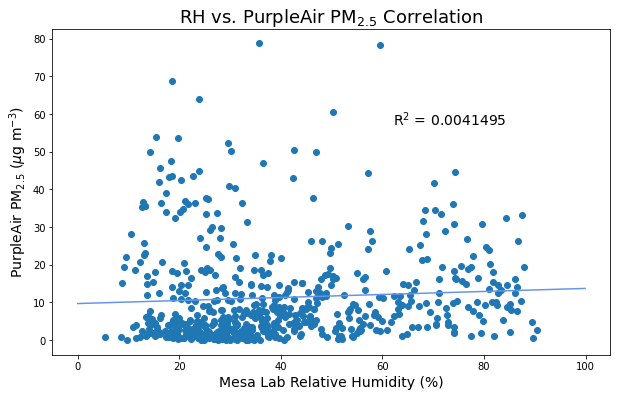

In [109]:
# Mesa Lab RH versus PurpleAir PM2.5 (corrected)

# calculating linear regression statistics 
slope, intercept, r_value, p_value, std_err = stats.linregress(mesa_new['RH'], \
      purpleair_new['PM2.5 (corrected)'])
print('Slope:',round(slope,2))
print('Intercept:', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')
r_squared = (r_value)**2
print('R_Squared:', r_squared)

# linear regression line to plot 
fit_x = np.arange(0,100,.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)

# plotting correlation between RH and PurpleAir Corrected PM2.5
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(mesa_new['RH'], purpleair_new['PM2.5 (corrected)'])
ax.plot(fit_x,fit_y,c='cornflowerblue')
ax.set_title(r'RH vs. PurpleAir PM$_{2.5}$ Correlation', **font2)
ax.set_xlabel('Mesa Lab Relative Humidity (%)', **font1)
ax.set_ylabel(r'PurpleAir PM$_{2.5} \ (\mu$g m$^{-3}$)', **font1)
plt.text(62, 57, r'R$^2$ = 0.0041495', fontsize=12, **font1)
plt.show()

# Notes: 
# Looks mostly similar to the EPA plot
# But y-axis (air quality) values are much higher!  

### Confidence Testing for RH and PurpleAir PM2.5 correlation 

**Null hypothesis:** The correlation between RH and PM2.5 measued by the PurpleAir sensor is positive. 

In [110]:
## Calculate the Fisher-Z Transformation mean, Barnes Ch. 2 Eq. 52
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #2')
print('Null Hypothesis: The true correlation is not zero.')
mu_Z=0.5*np.log((1+r_value)/(1-r_value)) 
print('mu_Z:',np.round(mu_Z,2))
N=len(purpleair_new['Date'])
df=N-3                    ## Calculate the degrees of freedom
sigma_Z=1/np.sqrt(df)     ## Calculate the Fisher-Z Transformation standard deviation Barnes Ch. 2 Equation 53
print('sigma_Z:',np.round(sigma_Z,2))

## Calculate the critical value, i.e., the t-statistic
tstat95=stats.t.ppf(0.975,df)  ## two-sided 95%
print('tstat95',round(tstat95,3))
## Calculate the confidence intervals on the mean (mu_Z)
Zmin=mu_Z-tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
Zmax=mu_Z+tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
print('Zmin (minimum 95% confidence interval)',round(Zmin,2))
print('Zmax (maximum 95% confidence interval)',round(Zmax,2))

## Convert to give a confidence interval on the correlation using Barnes Ch. 2 Eq. 55
rho_min=np.tanh(Zmin)
rho_max=np.tanh(Zmax)
print('Rhomin (minimum 95% confidence interval for true r_value):',round(rho_min,2))
print('Rhomax (maximum 95% confidence interval for true r_value):',round(rho_max,2))

print('If the confidence bounds do include 0 -- we reject the null hypothesis')
print('If the confidence bounds do not include 0 -- we fail to reject the null hypothesis')

# the confidence bounds include zero 
# therefore, we reject the null hypothesis
# we cannot say that the PurpleAir PM2.5 is positivelty correlated with RH 

ASSESS SIGNIFICANCE OF REGRESSION METHOD #2
Null Hypothesis: The true correlation is not zero.
mu_Z: 0.06
sigma_Z: 0.04
tstat95 1.964
Zmin (minimum 95% confidence interval) -0.02
Zmax (maximum 95% confidence interval) 0.15
Rhomin (minimum 95% confidence interval for true r_value): -0.02
Rhomax (maximum 95% confidence interval for true r_value): 0.14
If the confidence bounds do include 0 -- we reject the null hypothesis
If the confidence bounds do not include 0 -- we fail to reject the null hypothesis


###**Step 4: Present results visually using 2-3 graphs**


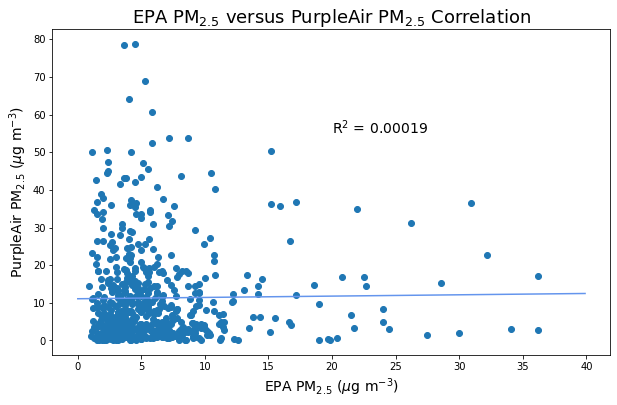

In [111]:
# plot 1

# linear regression line to plot 
slope, intercept, r_value, p_value, std_err = stats.linregress(epa_new['PM2.5'],\
      purpleair_new['PM2.5 (corrected)'])
fit_x0 = np.arange(0,40,.1);
fit_y0 = [];
for i in fit_x0:
    fit_y0.append(slope*i + intercept)
 
# plotting PM2.5 correlation for EPA vs PurpleAir 
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(epa_new['PM2.5'], purpleair_new['PM2.5 (corrected)'])
ax.plot(fit_x0,fit_y0,c='cornflowerblue')
ax.set_title(r'EPA PM$_{2.5}$ versus PurpleAir PM$_{2.5}$ Correlation', **font2)
ax.set_xlabel(r'EPA PM$_{2.5} \ (\mu$g m$^{-3}$)', **font1)
ax.set_ylabel(r'PurpleAir PM$_{2.5} \ (\mu$g m$^{-3}$)', **font1)
plt.text(20, 55, r'R$^2$ = 0.00019', fontsize=12, **font1)
plt.show()

**Figure 1:** There is very little correlation between PM2.5 measurements between the two sensors. When confidence testing was conducted with a null hypothesis that there would be a positive correlation between the sensors, the 95% confidence intervals included zero so we rejected the null hypotheis. This supports the lack of correlation shown in the graph.  
This could be a result of spatial variability of PM2.5 over the few kilometers in between sensors. 

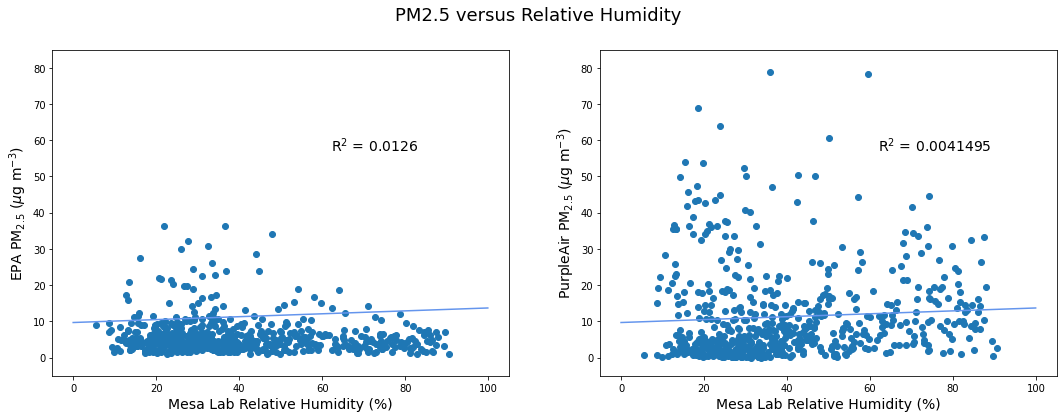

In [112]:
# plot 2
# plotting correlation between RH and PM2.5

# linear regression lines to plot 
# EPA
slope, intercept, r_value, p_value, std_err = stats.linregress(mesa_new['RH'], \
      epa_new['PM2.5'])
fit_x1 = np.arange(0,100,.1);
fit_y1 = [];
for i in fit_x1:
    fit_y1.append(slope*i + intercept)
#PurpleAir 
slope, intercept, r_value, p_value, std_err = stats.linregress(mesa_new['RH'], \
      purpleair_new['PM2.5 (corrected)'])
fit_x2 = np.arange(0,100,.1);
fit_y2 = [];
for i in fit_x2:
    fit_y2.append(slope*i + intercept)
  
# plotting EPA data in first subplot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('PM2.5 versus Relative Humidity', **font2)
ax1.scatter(mesa_new['RH'], epa_new['PM2.5'])
ax1.plot(fit_x1,fit_y2,c='cornflowerblue')
ax1.set_xlabel('Mesa Lab Relative Humidity (%)', **font1)
ax1.set_ylabel(r'EPA PM$_{2.5} \ (\mu$g m$^{-3}$)', **font1)
ax1.set_xlim(-5, 105)
ax1.set_ylim(-5, 85)
ax1.text(62, 57, r'R$^2$ = 0.0126', fontsize=12, **font1)

# plotting PurpleAir data in second subplot 
ax2.scatter(mesa_new['RH'], purpleair_new['PM2.5 (corrected)'])
ax2.plot(fit_x2,fit_y2,c='cornflowerblue')
ax2.set_xlabel('Mesa Lab Relative Humidity (%)', **font1)
ax2.set_ylabel(r'PurpleAir PM$_{2.5} \ (\mu$g m$^{-3}$)', **font1)
ax2.text(62, 57, r'R$^2$ = 0.0041495', fontsize=12, **font1)
ax2.set_xlim(-5, 105)
ax2.set_ylim(-5, 85)
plt.show()

**Figure 2:** There is not a significant correlation between relative humidity and PM2.5 measurements for either sensor. Confidence testing confirmed that this is the case. My hypothesis that the PurpleAir sensor would be impacted by humidity and the EPA sensor would not was not true; neither sensor exhibited a correlation with humidity.   
This could be due to the local climate and impacts of wildfire smoke during this time period. There were many smoky days in Boulder during summer 2020 and 2021 which typically occue when relative humidity is low, which could impact the results.  
Furthermore, the PurpleAir sensor shows higher values of PM2.5 than the EPA sensor despite being located in a more rural location where it is less likely to be influenced by urban pollution. This effect in which PurpleAir sensors read high compared to reference standards has been shown in numerous studies. 

###**Summary**: 
I hypothesized that particulate matter 2.5 measurements from a low-cost PurpleAir sensor would be influenced by relative humidity whereas the measurements from an EPA regulatory-grade sensor would not, but my analyses show that for both instruments PM2.5 was not correlated with relative humidity. This could be a result of how Boulder had many days with poor air quality and low relative humidity during wildfire season. Looking at a different location (such as Atlanta, GA which has high humidity and low influence of wildfire smoke) may be able to better answer the question of if PurpleAir sensor PM2.5 measurements are more stronly influenced by humidity than reference standards. 